In [4]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

In [5]:
from GraphST import GraphST

In [6]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = 'C:/Users/AGNISH/.conda/envs/GraphST/Lib/R/'

In [7]:
# the number of clusters
n_clusters = 5

In [8]:
dataset = 'GSE198353_mmtv_pymt'

In [9]:
# input_dir = 'C:/Users/AGNISH/Desktop/IITK/VSCode/GraphST/151673/'
# adata = sc.read_10x_h5(input_dir +'filtered_feature_bc_matrix.h5')
# adata.var_names_make_unique()

# read data
file_fold = 'C:/Users/AGNISH/GraphST/Data/SPOTS_Landau/' + str(dataset) #please replace 'file_fold' with the download path
adata = sc.read_visium(file_fold, count_file='GSE198353_mmtv_pymt_GEX_filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()

c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [10]:
adata.obs

,in_tissue,array_row,array_col
AAACAAGTATCTCCCA-1,1,50,102
AAACACCAATAACTGC-1,1,59,19
AAACAGGGTCTATATT-1,1,47,13
AAACAGTGTTCCTGGG-1,1,73,43
AAACATGGTGAGAGGA-1,1,62,0
...,...,...,...
TTGTTGGCAATGACTG-1,1,76,30
TTGTTTCACATCCAGG-1,1,58,42
TTGTTTCATTAGTCTA-1,1,60,30
TTGTTTCCATACAACT-1,1,45,27


In [11]:
adata.var

,gene_ids,feature_types,genome
Xkr4,ENSMUSG00000051951,Gene Expression,MMTV_PyMT_gex-mm10-2020-A
Gm1992,ENSMUSG00000089699,Gene Expression,MMTV_PyMT_gex-mm10-2020-A
Gm19938,ENSMUSG00000102331,Gene Expression,MMTV_PyMT_gex-mm10-2020-A
Gm37381,ENSMUSG00000102343,Gene Expression,MMTV_PyMT_gex-mm10-2020-A
Rp1,ENSMUSG00000025900,Gene Expression,MMTV_PyMT_gex-mm10-2020-A
...,...,...,...
AC133095.2,ENSMUSG00000095475,Gene Expression,MMTV_PyMT_gex-mm10-2020-A
AC133095.1,ENSMUSG00000094855,Gene Expression,MMTV_PyMT_gex-mm10-2020-A
AC234645.1,ENSMUSG00000095019,Gene Expression,MMTV_PyMT_gex-mm10-2020-A
AC149090.1,ENSMUSG00000095041,Gene Expression,MMTV_PyMT_gex-mm10-2020-A


In [12]:
adata

AnnData object with n_obs × n_vars = 1978 × 32286
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [13]:
# define model
model = GraphST.GraphST(adata, device=device)

# train model
adata = model.train()

Begin to train ST data...


100%|██████████| 600/600 [08:57<00:00,  1.12it/s]


Optimization finished for ST data!


In [14]:
adata

AnnData object with n_obs × n_vars = 1978 × 32286
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

In [15]:
# set radius to specify the number of neighbors considered during refinement
radius = 50

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [24]:
# add ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values

In [25]:
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI

print('Dataset:', dataset)
print('ARI:', ARI)

c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Dataset: 151673
ARI: 0.6331903767517718


c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\umap\distances.py:1086: NumbaDepreca

<Axes: title={'center': 'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

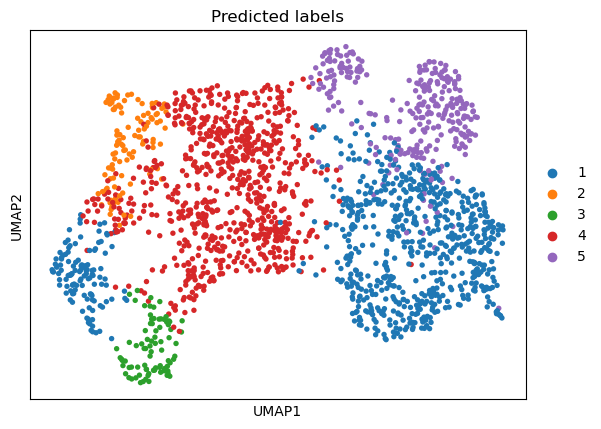

In [17]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)

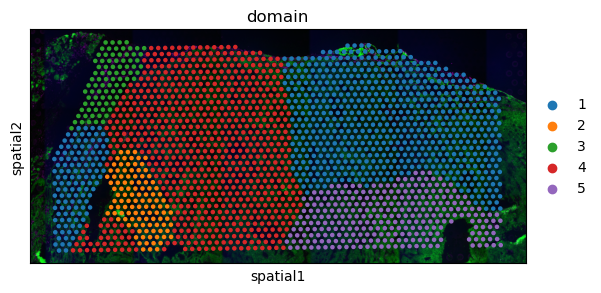

In [16]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              #color=["ground_truth", "domain"],
              color=["domain"],
              #title=["Ground truth", "ARI=%.4f"%ARI],
              show=True)

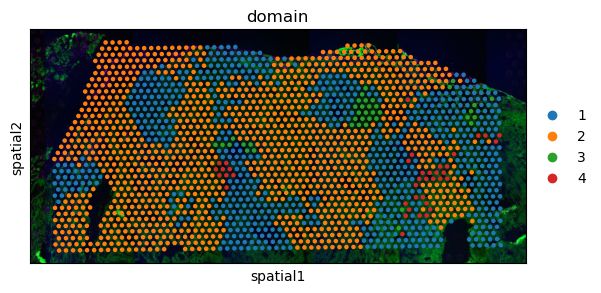

In [37]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              #color=["ground_truth", "domain"],
              color=["domain"],
              #title=["Ground truth", "ARI=%.4f"%ARI],
              show=True)

c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

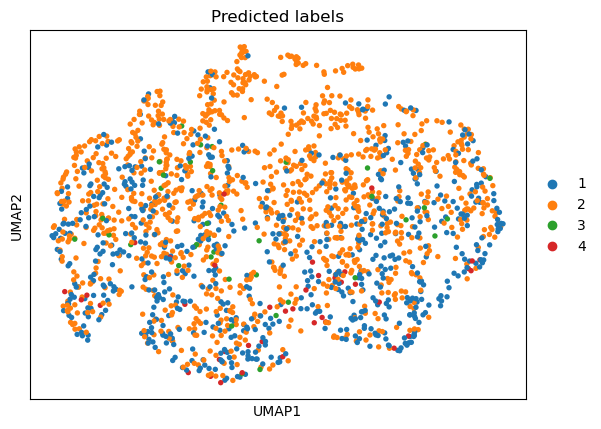

In [38]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)